In [1]:
from glob import glob
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import keras
from keras import backend as K
from tensorflow.keras import optimizers
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
import os


batch_size = 128
n_epochs = 12
per_sample_normalization = True
data_augmentation = True
globalAVGPooling = False
drop_out = True
capacity = ['low', 'high'][1]
last_layer_activation = ['softmax', 'sigmoid', None][1]
loss = ['categorical_crossentropy', 'binary_crossentropy', 'mean_squared_error', 'mean_absolute_error'][1]
txt = 'rnd'
img_size = 224
num_classes = 20
img_with_padding = False
voc_classes = {'aeroplane': 0, 1, 2, 3, 4, 5, 'car': 6, 7, 8, 'cow': 9, 'diningtable': 10
               , 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}
voc_class_colors = {'aeroplane': [128, 0, 0], 'bicycle': [0, 128, 0], 'bird': [128, 128, 0], 'boat': [0, 0, 128], 'bottle': [128, 0, 128]
                    , 'bus': [0, 128, 128], 'car': [128, 128, 128], 'cat': [64, 0, 0], 'chair': [192, 0, 0], 'cow': [64, 128, 0]
                    , 'diningtable': [192, 128, 0], 'dog': [64, 0, 128], 'horse': [192, 0, 128], 'motorbike': [64, 128, 128], 'person': [192, 128, 128]
                    , 'pottedplant': [0, 64, 0], 'sheep': [128, 64, 0], 'sofa': [0, 192, 0], 'train': [128, 192, 0], 'tvmonitor': [0, 64, 128]
                    , 'object_class_border': [224, 224, 192]}


In [2]:
# Download and untar voc dataset
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
!tar xf VOCtrainval_06-Nov-2007.tar
print('VOCtrainval_06-Nov-2007.tar has been uncompressed successfully.')

--2022-03-09 22:04:30--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  31.1MB/s    in 15s     

2022-03-09 22:04:45 (29.4 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]

VOCtrainval_06-Nov-2007.tar has been uncompressed successfully.


In [4]:
os.listdir()

['cnn_cifar10.ipynb', 'cnn_voc.ipynb', 'cnn_voc2.ipynb']

In [5]:
# Read and format data
def read_content(xml_file: str):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []
    list_with_all_objects = []
    for boxes in root.iter('object'):

        classname = boxes.find("name").text
        list_with_all_objects.append(voc_classes[classname])

        ymin, xmin, ymax, xmax = None, None, None, None

        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)

        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)

    return list_with_all_objects, list_with_all_boxes


files = glob('../VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/*.jpg')

n_samples = len(files)
files = files[:n_samples]
x_train, y_train, x_test, y_test = [], [], [], []

np.random.seed(0)
ridx = np.random.randint(0, n_samples, int(n_samples*0.2))
train_test_split = np.zeros(n_samples)
train_test_split[ridx] = 1
for f, i in zip(files, range(n_samples)):
    img = cv2.imread(f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    if img_with_padding:
        catdim = 0
        if img.shape[0] > img.shape[1]:
            cataxis = 1
            catdim = int((img.shape[0] - img.shape[1]) / 2)
            catarray = np.zeros((img.shape[0], catdim, img.shape[2]), img.dtype)
            img = np.concatenate((catarray, img, catarray), axis=cataxis)
        elif img.shape[0] < img.shape[1]:
            cataxis = 0
            catdim = int((img.shape[1] - img.shape[0]) / 2)
            catarray = np.zeros((catdim, img.shape[1], img.shape[2]), img.dtype)
            img = np.concatenate((catarray, img, catarray), axis=cataxis)
    img = cv2.resize(img, (img_size, img_size))
    
    if train_test_split[i]:
        x_test.append(img)
    else:
        x_train.append(img)
    
    classes = np.zeros(num_classes)
    root, name = f.split('JPEGImages', 1)
    cnames, _ = read_content(root+'Annotations'+name[:-3]+'xml')
    for c in cnames:
        classes[c] = 1.0
            
    if train_test_split[i]:
        y_test.append(classes)
    else:
        y_train.append(classes)
    
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

print(x_train.shape[0])
print(x_test.shape[0])

4110
901


In [14]:
rgb_weights = [0.2989, 0.5870, 0.1140]

def convert_to_gray(color):
    return round(color[0]*rgb_weights[0] + color[1]*rgb_weights[1] + color[2]*rgb_weights[2])

def color2idx(c):
  return c[0]*256**2 + c[1]*256 + c[2]

colors = [[128, 0, 0], [0, 128, 0], [128, 128, 0],[0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], 
    [192, 0, 0], [64, 128, 0], [192, 128, 0], [64, 0, 128], 
    [192, 0, 128], [64, 128, 128], [192, 128, 128],
    [0, 64, 0], [128, 64, 0], [0, 192, 0], 
    [128, 192, 0], [0, 64, 128], [224, 224, 192]]


grays = [color2idx(color) for color in colors]

print(grays)

[8388608, 32768, 8421376, 128, 8388736, 32896, 8421504, 4194304, 12582912, 4227072, 12615680, 4194432, 12583040, 4227200, 12615808, 16384, 8404992, 49152, 8437760, 16512, 14737600]


In [10]:
path = '../VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/SegmentationClass/' + '000032' + '.png'
import cv2
im_class = cv2.imread(path)
im_class = cv2.cvtColor(im_class, cv2.COLOR_BGR2GRAY)

print(np.unique(im_class))


[  0  38 147 220]


In [7]:
colors = np.array(colors)
print(colors.shape)
colors_bgr = colors.transpose((1, 0, 2))

(21, 3)


ValueError: axes don't match array

In [12]:
# Check out the segmentation data

files = glob('../VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/SegmentationClass/*.png')
print(len(files))

# Read files and show the images
id = 100
file = files[id].split('\\')[-1].split('.')[0]
print(file)
rgb_file = '../VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/' + file + '.jpg'
class_file = '../VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/SegmentationClass/' + file + '.png'
object_file = '../VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/SegmentationObject/' + file + '.png'

im_rgb = cv2.imread(rgb_file)
im_rgb = cv2.cvtColor(im_rgb, cv2.COLOR_BGR2RGB)
plt.imshow(im_rgb)
plt.show()

im_class = cv2.imread(class_file)
im_class = cv2.cvtColor(im_class, cv2.COLOR_BGR2RGB)
plt.imshow(im_class)
plt.show()

im_object = cv2.imread(object_file)
im_object = cv2.cvtColor(im_object, cv2.COLOR_BGR2RGB)
plt.imshow(im_object)
plt.show()

# Read out the object instances

# First we convert the class colors into unique indices
def color2idx(c):
  return c[0]*256**2 + c[1]*256 + c[2]

voc_class_indices = {}
for k in voc_class_colors.keys():
  color = voc_class_colors[k]
  voc_class_indices[color2idx(color)] = k


print(voc_class_indices)

# Then we convert im_class and im_object colors into indices.
# Note the indices on im_object are meaningless and are just used to differentiate the objects' pixels.
im_class = color2idx(im_class.transpose((2,0,1)))
im_object = color2idx(im_object.transpose((2,0,1)))


# Then we go over the pixels and build the segmented images in a dictionary
object_container = {}
counter = 0
curr_classes = np.unique(im_class) # the first and the last ones are background and borders respectively
print(curr_classes[1:-1])
for idx in curr_classes[1:-1]:
  cls = voc_class_indices[idx]
  im_class_object = (im_class==idx).astype(np.int32) * im_object
  curr_objects = np.unique(im_class_object) # the first and the last ones are background and borders respectively
  print(f'Curr objects {curr_objects}')
  for idx in curr_objects[1:]:
    mask_object = (im_class_object==idx).astype(np.uint8)
    pix_idx = np.where(mask_object)
    y_min, y_max, x_min, x_max = [pix_idx[0][0], pix_idx[0][-1], np.min(pix_idx[1]), np.max(pix_idx[1])]

    mask_object_crop = mask_object[y_min:y_max, x_min:x_max]
    rgb_object_crop = im_rgb[y_min:y_max, x_min:x_max]

    object_container[counter] = {'class': cls, 'rgb': rgb_object_crop, 'mask': mask_object_crop[:,:,np.newaxis]}
    counter += 1

    plt.imshow(rgb_object_crop)
    plt.show()

# Corrupt an image
im = cv2.imread('../VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/000007.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
H, W, _ = im.shape
plt.imshow(im)
plt.show()

for k in object_container.keys():
  obj = object_container[k]
  h, w, _ = obj['rgb'].shape

  y, x = [np.random.randint(0, H-h), np.random.randint(0, W-w)]
  im[y:y+h, x:x+w, :] = im[y:y+h, x:x+w, :] * (1-obj['mask']) + obj['rgb'] * obj['mask']

  plt.imshow(im)
  plt.show()


NameError: name 'glob' is not defined

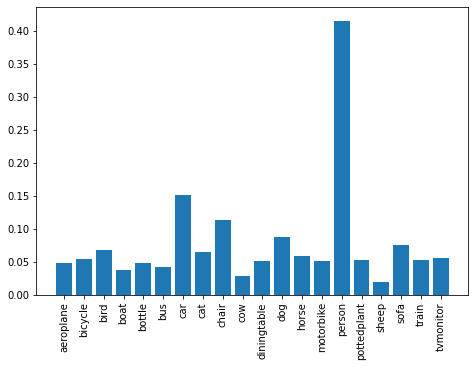

In [ ]:
# plot the data distribution
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labs = voc_classes.keys()
data_balance = np.sum(y_train, 0) / y_train.shape[0]
ax.bar(labs,data_balance)
plt.xticks([i for i in range(20)], labs, rotation='vertical')
plt.show()


In [ ]:
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
if capacity is 'high':
  model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
if drop_out:
  model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
if capacity is 'high':
  model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
if drop_out:
  model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
if capacity is 'high':
  model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
if drop_out:
  model.add(Dropout(0.4))

if globalAVGPooling:
  model.add(GlobalAveragePooling2D())
else:
  model.add(Flatten())

model.add(Dense(num_classes, activation=last_layer_activation))
 
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 activation_6 (Activation)   (None, 224, 224, 32)      0         
                                                                 
 batch_normalization_6 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 activation_7 (Activation)   (None, 224, 224, 32)      0         
                                                                 
 batch_normalization_7 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                      

In [ ]:
#training

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_metric(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#data augmentation
val_data_gen_args = dict(rescale = None if per_sample_normalization else 1./255,
                     samplewise_center=True if per_sample_normalization else False,
                     samplewise_std_normalization=True if per_sample_normalization else False)
train_data_gen_args = dict(rescale = None if per_sample_normalization else 1./255,
                     samplewise_center=True if per_sample_normalization else False,
                     samplewise_std_normalization=True if per_sample_normalization else False,
                     rotation_range=20,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2) if data_augmentation else val_data_gen_args
training_datagen = ImageDataGenerator(train_data_gen_args)
training_set = training_datagen.flow(x_train, y_train, batch_size=batch_size)
val_datagen = ImageDataGenerator(val_data_gen_args)
val_set = val_datagen.flow(x_test, y_test, batch_size=batch_size)
 
opt_rms = optimizers.RMSprop(learning_rate=0.001, decay=1e-6)
model.compile(loss=loss, optimizer=opt_rms, metrics=['AUC', f1_metric])
mdl_fit = model.fit_generator(training_set, steps_per_epoch=x_train.shape[0] // batch_size, 
                    epochs=n_epochs, verbose=1, validation_data=val_set)

Epoch 1/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


32/32 [==============================] - 23s 640ms/step - loss: 0.3449 - auc: 0.9350 - f1_metric: 0.6294 - val_loss: 0.6318 - val_auc: 0.7465 - val_f1_metric: 0.3166
Epoch 2/12
32/32 [==============================] - 20s 627ms/step - loss: 0.2169 - auc: 0.9662 - f1_metric: 0.7633 - val_loss: 0.9177 - val_auc: 0.7096 - val_f1_metric: 0.2552
Epoch 3/12
32/32 [==============================] - 20s 630ms/step - loss: 0.1806 - auc: 0.9779 - f1_metric: 0.7998 - val_loss: 0.8563 - val_auc: 0.7154 - val_f1_metric: 0.2797
Epoch 4/12
32/32 [==============================] - 20s 633ms/step - loss: 0.1907 - auc: 0.9766 - f1_metric: 0.7996 - val_loss: 0.7635 - val_auc: 0.7177 - val_f1_metric: 0.2744
Epoch 5/12
32/32 [==============================] - 20s 636ms/step - loss: 0.1339 - auc: 0.9834 - f1_metric: 0.8421 - val_loss: 0.6538 - val_auc: 0.7397 - val_f1_metric: 0.3327
Epoch 6/12
32/32 [==============================] - 21s 640ms/step - loss: 0.1187 - auc: 0.9863 - f1_metric: 0.8664 - val_loss

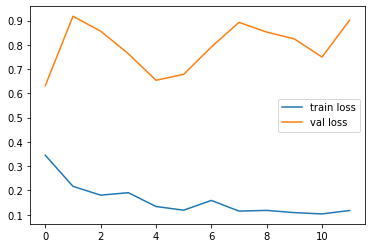

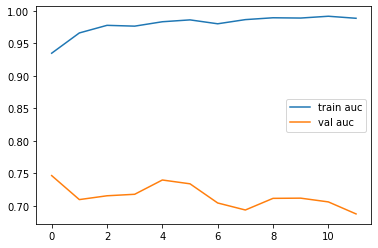

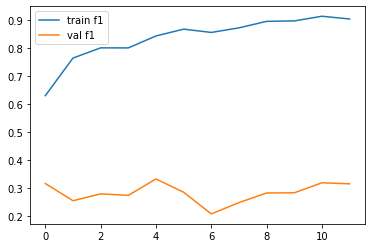

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(mdl_fit.history['loss'], label='train loss')
plt.plot(mdl_fit.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig(txt+'_LossVal_loss')

# plot the AUC
plt.plot(mdl_fit.history['auc'], label='train auc')
plt.plot(mdl_fit.history['val_auc'], label='val auc')
plt.legend()
plt.show()
plt.savefig(txt+'_aucVal')

# plot the F1
plt.plot(mdl_fit.history['f1_metric'], label='train f1')
plt.plot(mdl_fit.history['val_f1_metric'], label='val f1')
plt.legend()
plt.show()
plt.savefig(txt+'_f1Val')

#save model to disk
model.save_weights('model.h5')